In [108]:
include(joinpath(pwd(), "MPC_functions.jl"))
using  Luna
import FFTW                    
import Luna: Hankel  
import NumericalIntegration: integrate, SimpsonEven          
import Dates                   
using LaTeXStrings
using Printf
using DSP
using HDF5
using PyPlot
pygui(true)
using Plots


In [109]:
PyPlot.rcdefaults() # reset to default
PyPlot.close("all")

# Set global plotting parameters for PyPlot.jl
PyPlot.rc("font", size=12)      #family="serif",
# PyPlot.rc("axes", titlesize=18, labelsize=16)
# PyPlot.rc("xtick", labelsize=12)
# PyPlot.rc("ytick", labelsize=12)
PyPlot.rc("lines", linewidth=2)
size_py = 0.393701*[20, 15]     # figure size
size_py_wide = 0.393701*[20, 8]# figure size in cm
res = 300                       # figure resolution (dpi)

300

In [110]:
# Set global plotting parameters for Plots.jl
default(
#       guidefont = font(16, "Times"),    # Axis label font
#       tickfont = font(14),              # Axis tick font
#       legendfontsize = 12,              # Legend font size
#       titlefont = font(18, "Arial"),    # Title font
        linewidth=2
  )
size_jl=(800,600)   # figure size in pixel
# closeall()


(800, 600)

## I) Read data from .h5 file

In [111]:
run = "run_2025_07_21__13_21_23"
run_path = joinpath("output", run)
save_figs = true

params = Dict()

# Open file read-only
h5open(joinpath(run_path, "output.h5"), "r") do file
    # List datasets/groups in the file
    println(keys(file))
    
    # Read dataset
    global Eωr0 = read(file["Eωr0"])
    global Eωr_in = read(file["Eωr_in"])
    global Eωr_out = read(file["Eωr_out"])

    # Read beam waists
    global w_z = read(file["w_z"]) 
    global w_min = read(file["w_min"]) 
    global w_mirr = read(file["w_mirr"]) 
    
    global ω = read(file["ω"])
    global t = read(file["t"])
    global r = read(file["r"])
    global z = read(file["z"])

    # file["params"] is a group with keys as parameter names
    param_group = file["params"]
    for name in keys(param_group)
        params[name] = read(param_group[name])
    end
end

["Eωr0", "Eωr_in", "Eωr_out", "params", "r", "t", "w_min", "w_mirr", "w_z", "z", "ω"]


Regenerate Hankel transform matrix "q", simulation grid as well as additional coordinate axes rsym, f and λ

In [112]:
q = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=2)                  # set up discrete Hankel transform matrix, transformation done along 2nd dimension 
q_1D = Hankel.QDHT(params["R_Hankel"], params["N_Hankel"], dim=1)               # to be applied to arrays that where integrated over ω, so r becomes 1rst dimension
rsym = Hankel.Rsymmetric(q)                                 # sampled radii [m] mirrored around and including r=0 so that rsym = [–rn, ...-r2, -r1, 0, r1, r2, ..., rn]

L = params["L"]
λ0 = params["λ0"]
λlims = (params["λmin"], params["λmax"])
trange_request = params["trange_request"]

grid = Grid.RealGrid(L, λ0, λlims, trange_request)               # set up time & space grid for gradient approximation
f = ω./2π                      # sampled linear frequencies [Hz]
λ = PhysData.wlfreq.(ω)         # sampled wavelengths [m]
λ[1] = 1.0                        # avoid "Inf" value for DC frequency

┌ Info: Freq limits 0.26 - 0.33 PHz
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:40
┌ Info: Samples needed: 3997.23, samples: 4096, δt = 500.35 as
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:44
┌ Info: Requested time window: 2000.0 fs, actual time window: 2049.4 fs
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:46
┌ Info: Grid: samples 2048 / 4096, ωmax 3.14e+15 / 6.28e+15
└ @ Luna.Grid C:\Users\muelderk\.julia\packages\Luna\7FAkO\src\Grid.jl:78


1.0

## II) Analyze final output (last propagation step of last pass)

### a) Input vs. output spectrum and spectral phase

In [113]:
Eωr0_in = Eωr0[:,1,1]
Eωr0_out = Eωr0[:,end,end]

1025-element Vector{ComplexF64}:
  -0.0007985931407307147 + 0.0im
   0.0006693442669327175 - 0.00047329182638070825im
  -0.0003116380610869471 + 0.0008229452327047832im
  -0.0001907072269298393 - 0.000952294336613417im
   0.0007176394419389541 + 0.0008131143814048689im
  -0.0011382656283626343 - 0.0004172416411629847im
   0.0013388890407342135 - 0.0001642547109470709im
   -0.001248108505449475 + 0.0008141323789416789im
   0.0008537956173870722 - 0.0013920384985745902im
 -0.00020838577433143467 + 0.0017629422808446975im
                         ⋮
   0.0009649059854805216 + 0.008753999262345076im
  -0.0042871060227339655 - 0.007909581995653456im
    0.007086661069014291 + 0.005802182671162601im
   -0.008887391120305004 - 0.0027208202044691587im
    0.009363974694159328 - 0.0008703346688195392im
   -0.008403231533626978 + 0.004407523331129943im
   0.0061289740651576325 - 0.007322523743843146im
   -0.002885189645420591 + 0.009140321849442716im
  -0.0008198996771851875 - 0.00956170695440019

In [114]:
ϕω_in = unwrap_phase(ω, t, Eωr0_in)
ϕω_out = unwrap_phase(ω, t, Eωr0_out)

ϕω_in = blank_phase(ω, abs2.(Eωr0_in), ϕω_in; level=0.05)
ϕω_out = blank_phase(ω, abs2.(Eωr0_out), ϕω_out; level=0.05)

1025-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

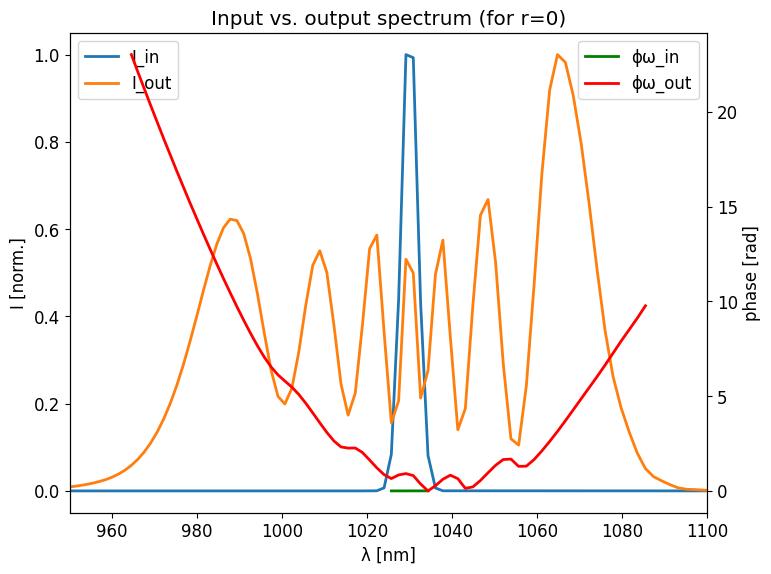

In [148]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("Input vs. output spectrum (for r=0)")
ax1.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_in)), label="I_in")
ax1.plot(λ.*1e9, Maths.normbymax(abs2.(Eωr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(λ.*1e9, ϕω_in, label="ϕω_in", color="green")
ax2.plot(λ.*1e9, ϕω_out, label="ϕω_out", color="red")
ax1.set_xlim(950, 1100)
# ax1.set_xlim(λlims[1]*1e9, λlims[2]*1e9)
ax1.set_xlabel("λ [nm]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectrum_in_vs_out.png"), dpi=res) 
end
plt.gcf()

### b) Input vs. output pulse

In [116]:
Etr0_in = Maths.hilbert(FFTW.irfft(Eωr0_in, length(t), 1))
Etr0_out = Maths.hilbert(FFTW.irfft(Eωr0_out, length(t), 1))

ϕt_in = unwrap(angle.(Etr0_in))
ϕt_out = unwrap(angle.(Etr0_out))

ϕt_in = blank_phase(t, abs2.(Etr0_in), ϕt_in; level=0.05)
ϕt_out = blank_phase(t, abs2.(Etr0_out), ϕt_out; level=0.05)

2048-element Vector{Float64}:
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
   ⋮
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN
 NaN

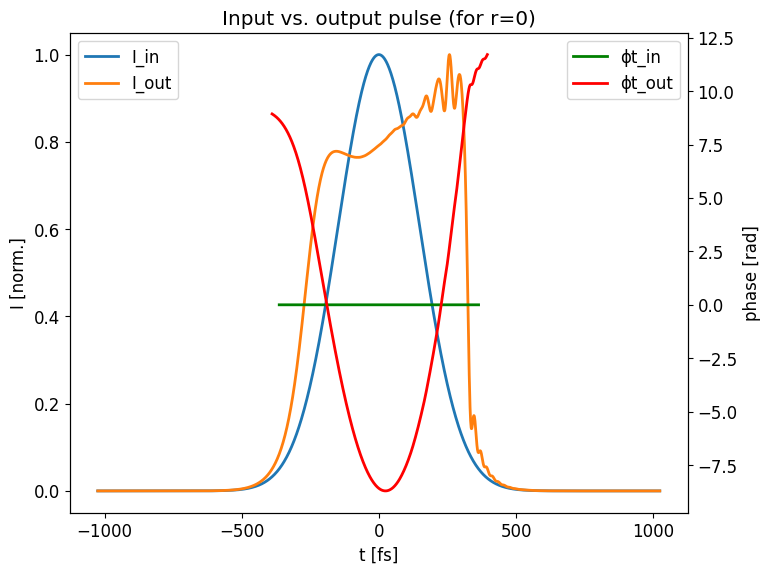

In [117]:
fig, ax1 = plt.subplots(figsize=size_py)
ax1.set_title("Input vs. output pulse (for r=0)")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_in)), label="I_in")
ax1.plot(t.*1e15, Maths.normbymax(abs2.(Etr0_out)), label="I_out")
ax2 = ax1.twinx()
ax2.plot(t.*1e15, detrend(ϕt_in), label="ϕt_in", color="green")
ax2.plot(t.*1e15, detrend(ϕt_out), label="ϕt_out", color="red")
# ax1.set_xlim(-200, 200)
ax1.set_xlabel("t [fs]")
ax1.set_ylabel("I [norm.]")
ax2.set_ylabel("phase [rad]")
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "pulse_in_vs_out.png"), dpi=res) 
end
plt.gcf()

### c) Spectral homogeinity across r

In [118]:
Irλ_out = transpose(Iwlfreq.(ω, abs2.(Eωr_out)))

256×1025 transpose(::Matrix{Float64}) with eltype Float64:
 0.0  3.34822e9   1.54168e10  …  4.82179e17  4.86804e17  4.88986e17
 0.0  3.3236e9    1.52305e10     5.13309e17  5.18449e17  5.20845e17
 0.0  3.27565e9   1.48847e10     5.7129e17   5.77361e17  5.80147e17
 0.0  3.21185e9   1.44147e10     6.55886e17  6.63281e17  6.66625e17
 0.0  3.1234e9    1.37977e10     7.68416e17  7.77511e17  7.81576e17
 0.0  3.01568e9   1.30685e10  …  9.06439e17  9.17536e17  9.22457e17
 0.0  2.8871e9    1.22404e10     1.0656e18   1.07891e18  1.08478e18
 0.0  2.73577e9   1.13302e10     1.236e18    1.25157e18  1.25843e18
 0.0  2.56068e9   1.03588e10     1.40373e18  1.4214e18   1.42919e18
 0.0  2.36525e9   9.36777e9      1.55026e18  1.56964e18  1.5782e18
 ⋮                            ⋱                          
 0.0  0.00375793  0.0229994      2.86879e6   2.49868e6   2.50987e6
 0.0  1.29072     5.09319        4.46828e7   4.4897e7    4.55567e7
 0.0  1.02246     4.02017        6.31738e7   6.34622e7   6.42074e7
 0.

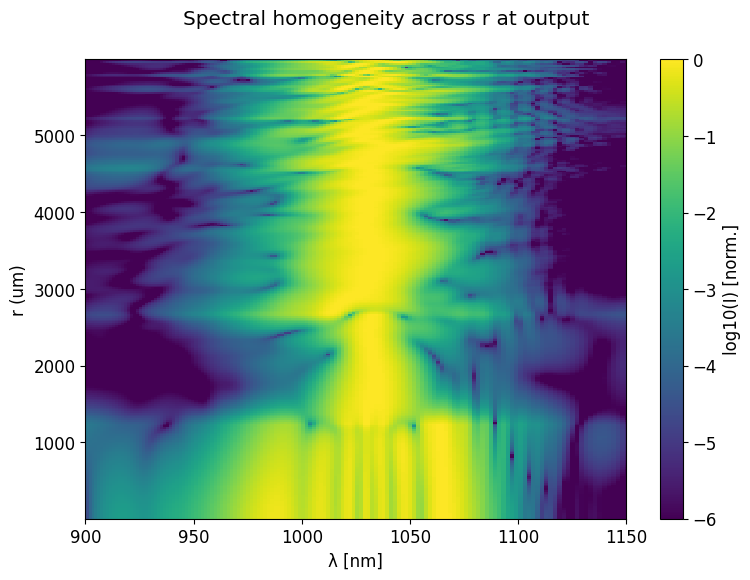

In [119]:
smallval = 1e-50

plt.figure(figsize=size_py)
plt.suptitle("Spectral homogeneity across r at output")
plt.pcolormesh(λ*1e9, r*1e6, Maths.log10_norm(Irλ_out .+smallval, 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log10(I) [norm.]")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
plt.xlabel("λ [nm]")
plt.ylabel("r (um)") 
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_homogeneity.png"), dpi=res) 
end
plt.gcf()

### d) Spatiotemporal profile

In [120]:
Etr_out = Maths.hilbert(FFTW.irfft(Eωr_out, length(t), 1))

2048×256 Matrix{ComplexF64}:
  -10.9705+17.8195im    -10.0197+19.7703im  …  -0.000411161-1.11802e-5im
  -3.48455-17.7374im    -5.56035-17.4883im      -1.23979e-5-0.00019472im
   14.1526+11.6523im      14.591+9.75572im       8.40194e-5-0.0001321im
  -20.9717+4.26147im    -19.4869+5.21207im      0.000261704+9.09184e-5im
   4.96563-21.9085im     3.76845-20.9234im     -0.000180179+0.000336745im
   16.1521+6.9804im      15.5982+5.80161im  …  -0.000333379-0.000295264im
   1.95865+7.74561im     2.92349+7.44052im      0.000386245-0.000266971im
 -0.312104+22.2366im  -0.0291152+22.883im       0.000175427+0.000427917im
  -52.0274+5.18362im    -52.3164+5.65263im     -0.000422638+9.77028e-5im
   -11.209-89.2453im    -12.0199-89.1495im      -5.79326e-5-0.00039014im
          ⋮                                 ⋱              ⋮
   124.741+7.32964im      122.44+4.11967im     -0.000444009-0.000976408im
  -62.8101+70.2838im    -59.7808+69.3912im  …    0.00131013+0.000470131im
  -9.65842-71.1927im    -9.57

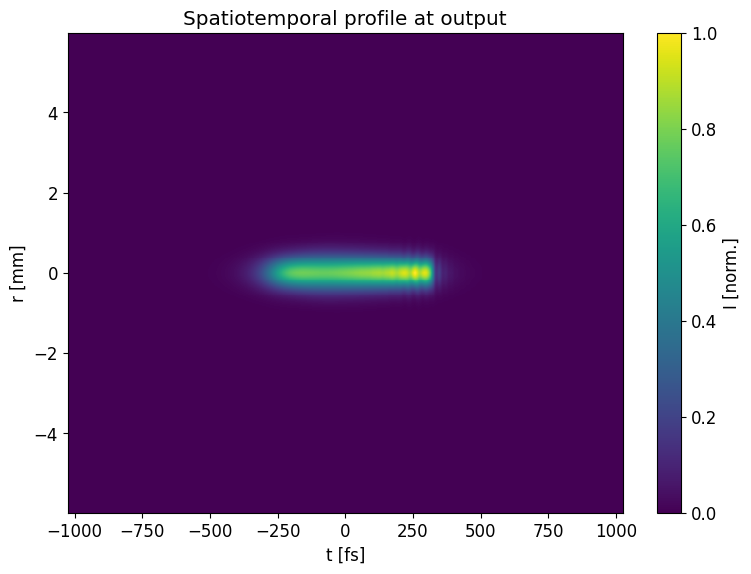

In [121]:
plt.figure(figsize=size_py) 
plt.title("Spatiotemporal profile at output")
plt.pcolormesh(t.*1e15, rsym.*1e3, Maths.normbymax(abs2.(Hankel.symmetric(Etr_out, q)')))
plt.colorbar(label="I [norm.]")
plt.xlabel("t [fs]")
plt.ylabel("r [mm]")
# plt.ylim(minimum(rsym*1e3), maximum(rsym*1e3))
# plt.xlim(minimum(t*1e15)/2, maximum(t*1e15)/2)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spatiotemporal_profile.png"), dpi=res) 
end
plt.gcf()

## III) Analyze overall pulse evolution across all passes

In [122]:
Nω = size(Eωr_in,1)
Nr = size(Eωr_in,2)
Nz = size(Eωr0,2)
Npass = size(Eωr0,3)

Nt = length(t)
Nrsym = length(rsym)

513

In [123]:
z_total = zeros(Nz, Npass)

for pass in 1:Npass 
    z_total[:,pass] = z .+ (pass-1)*z[end]
end

z_total = vcat(z_total...)

2010-element Vector{Float64}:
 0.0
 0.002755
 0.00551
 0.008265
 0.01102
 0.013775
 0.01653
 0.019285
 0.02204
 0.024795
 ⋮
 5.48796
 5.490715000000001
 5.49347
 5.496225000000001
 5.49898
 5.501735
 5.5044900000000005
 5.507245
 5.510000000000001

### a) Beams Caustic 

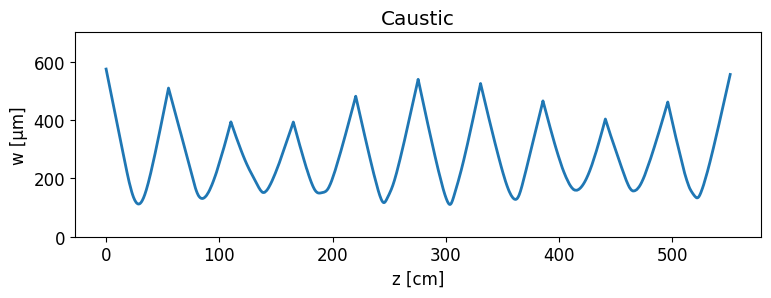

In [149]:
# PLOT CAUSTIC
plt.figure(figsize=size_py_wide) 
plt.title("Caustic")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, w_z.*1e6)
plt.xlabel("z [cm]")
plt.ylabel("w [μm]")
plt.ylim(0,700)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

### b) Minimum beam waist per pass

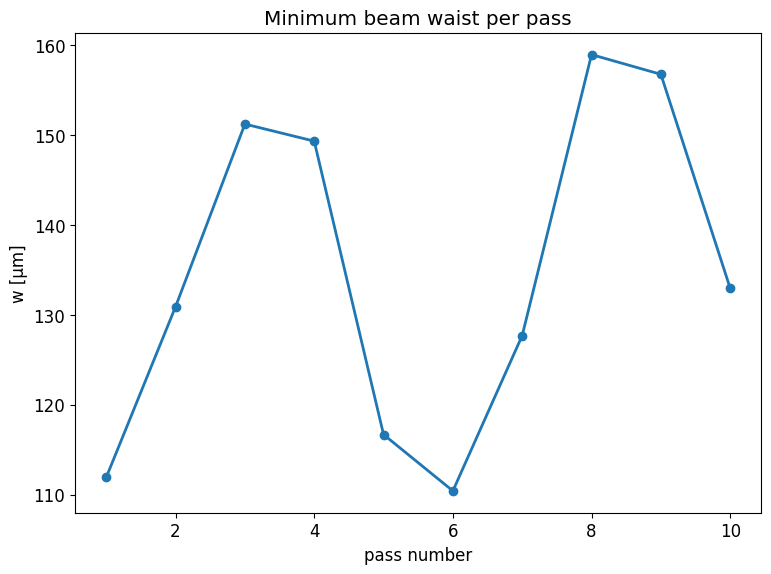

In [125]:
# PLOT minimum beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Minimum beam waist per pass")
plt.plot(1:Npass, w_min.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
# plt.ylim(95,125)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_minimum.png"), dpi=res) 
end
plt.gcf()

### c) Mirror beam waist per pass

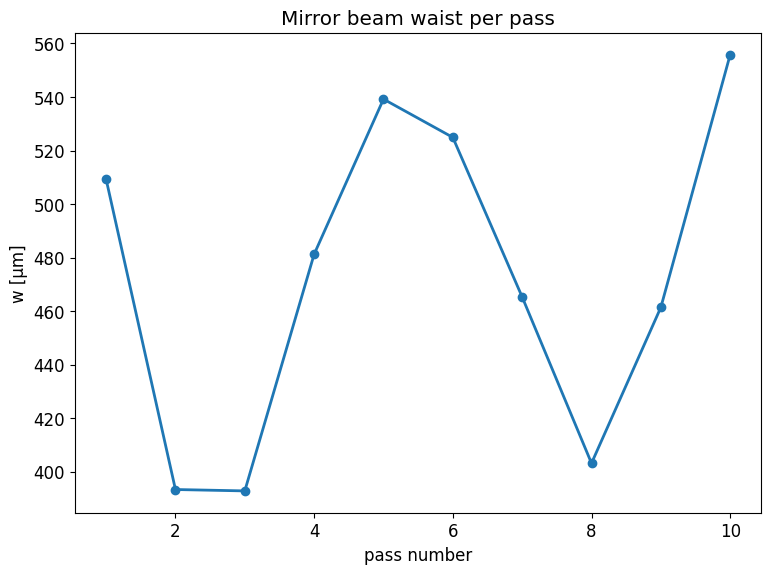

In [126]:
# PLOT mirror beam waist per pass
plt.figure(figsize=size_py) 
plt.title("Mirror beam waist per pass")
plt.plot(1:Npass, w_mirr.*1e6, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("w [μm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

### d) Spectral evolution (vs. λ)

In [127]:
Iωr0 = abs2.(Eωr0)    # convert to intensity
Iλr0 = Iwlfreq.(ω, Iωr0)

1025×201×10 Array{Float64, 3}:
[:, :, 1] =
 0.0         0.0         0.0         …  0.0         0.0         0.0
 2.76765e23  2.27848e15  6.6854e15      5.35183e14  1.77791e14  5.90632e13
 1.06289e23  3.62382e16  3.32905e16     3.85504e15  1.28067e15  4.25445e14
 1.67458e23  1.82037e17  9.92184e16     1.50348e16  4.99465e15  1.65925e15
 7.44372e23  5.69262e17  2.35995e17     4.23096e16  1.40555e16  4.66933e15
 2.51192e24  1.37105e18  4.86073e17  …  9.67453e16  3.21394e16  1.06769e16
 2.4257e24   2.7961e18   9.01172e17     1.91792e17  6.37146e16  2.11664e16
 2.38505e24  5.07893e18  1.54022e18     3.42731e17  1.13857e17  3.7824e16
 2.47137e24  8.4685e18   2.46692e18     5.66028e17  1.88038e17  6.24673e16
 6.2919e24   1.32158e19  3.74693e18     8.78626e17  2.91885e17  9.69659e16
 ⋮                                   ⋱                          ⋮
 8.13447e29  8.12173e24  2.12923e25     3.88406e23  1.29031e23  4.28648e22
 8.1617e29   8.75406e24  2.29233e25     3.95889e23  1.31517e23  4.36906e22

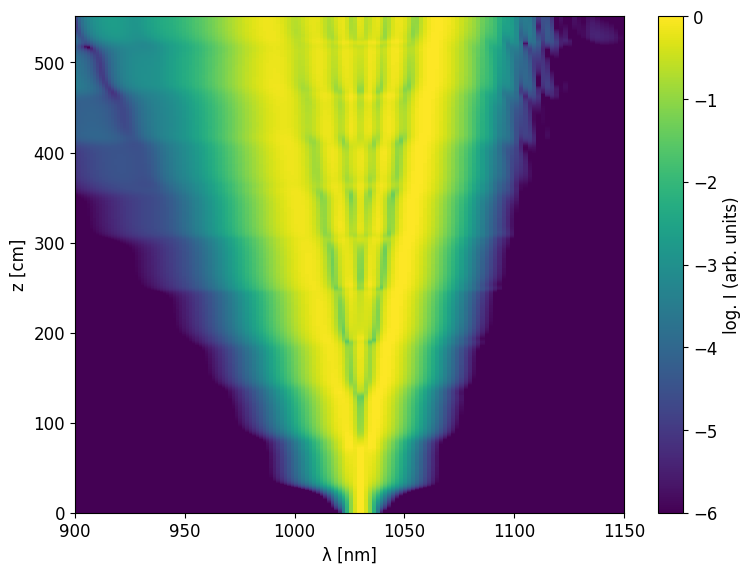

In [128]:
Iλr0_fused = hcat(eachslice(Iλr0, dims=3)...)

#+++++ PLOT 4: spectral evolution (against λ) 
plt.figure(figsize=size_py)
# plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(λ.*1e9, z_total.*1e2, Maths.log10_norm(transpose(Iλr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(λlims[1]*1e9, λlims[2]*1e9)
# plt.ylim(0,75)
plt.xlabel("λ [nm]")
plt.ylabel("z [cm]")
# plt.xlim(700,1400)
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_wl.png"), dpi=res) 
end
plt.gcf()


In [129]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.normbymax(Iλr0_fused[:, i]),
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(0, 1), 
#     xlabel=("λ [nm]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution.gif"), fps=24)

In [130]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(λ.*1e9, Maths.log10_norm(Iλr0_fused[:, i] .+smallval), 
#     # size=size_jl,
#     xlim=(λlims[1]*1e9, λlims[2]*1e9), 
#     ylim=(-6, 0), 
#     xlabel=("λ [nm]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2, digits=1)) cm", 
#     title="Spectral evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "spectral_evolution_log.gif"), fps=24)

### E) Spectral evolution (vs. f)

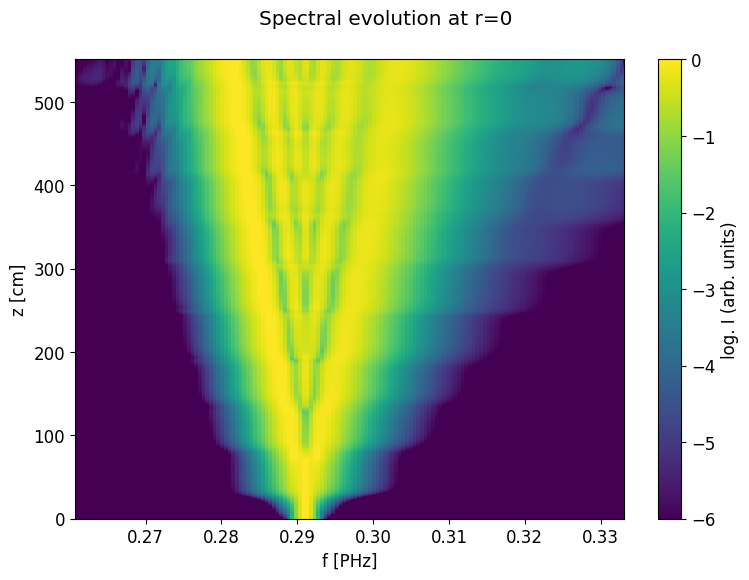

In [131]:
Iωr0_fused = hcat(eachslice(Iωr0, dims=3)...)

#+++++ PLOT 5: spectral evolution (against f) 
plt.figure(figsize=size_py)
plt.suptitle("Spectral evolution at r=0")
plt.pcolormesh(f*1e-15, z_total.*1e2, Maths.log10_norm(transpose(Iωr0_fused[:, :] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(PhysData.wlfreq(λlims[2])/2pi*1e-15, PhysData.wlfreq(λlims[1])/2pi*1e-15)
plt.xlabel("f [PHz]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "spectral_evolution_f.png"), dpi=res) 
end
plt.gcf()

### f) Temporal evolution

In [132]:
Etr0 = zeros((size(Eωr0,1)-1)*2, size(Eωr0,2), size(Eωr0,3))
Itr0 = similar(Etr0)

for pass in 1:size(Eωr0,3)
    Etr0[:,:,pass] = FFTW.irfft(Eωr0[:,:,pass], length(t), 1)  # pulse for r=0
    Itr0[:,:,pass] = abs2.(Maths.hilbert(Etr0[:,:,pass]))           # temporal intensity for r=0
end

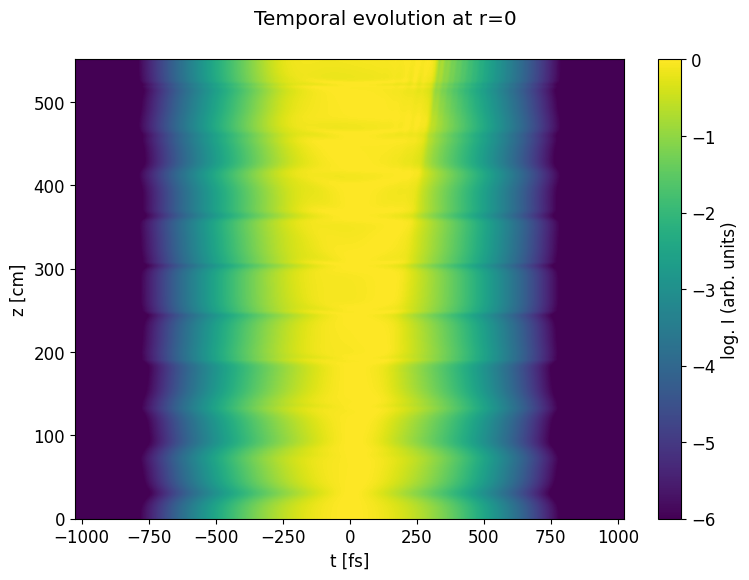

In [133]:
Itr0_fused = hcat(eachslice(Itr0, dims=3)...)

#+++++ PLOT 4: temporal evolution 
plt.figure(figsize=size_py)
plt.suptitle("Temporal evolution at r=0")
plt.pcolormesh(t.*1e15, z_total.*1e2, Maths.log10_norm(transpose(Itr0_fused[:,:] .+smallval), 2))   
plt.clim(-6, 0)    
plt.colorbar(label="log. I (arb. units)")
plt.xlim(minimum(t)*1e15, maximum(t)*1e15)
plt.xlabel("t [fs]")
plt.ylabel("z [cm]")
plt.tight_layout()
if save_figs 
    plt.savefig(joinpath(run_path, "temporal_evolution.png"), dpi=res) 
end
plt.gcf()

In [134]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.normbymax(Itr0_fused[:, i]),
#     # size=size_jl,
#     ylim=(0, 1), 
#     xlabel=("t [fs]"),
#     ylabel=("I [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution.gif"), fps=24)

In [135]:
# # Create an animation object
# anim = @animate for i in 1:20:length(z_total)
#     Plots.plot(t.*1e15, Maths.log10_norm(Itr0_fused[:, i] .+smallval),
#     # size=size_jl,
#     ylim=(-6, 0), 
#     xlabel=("t [fs]"),
#     ylabel=("log10(I) [norm.]"), 
#     label="z =  $(round(z_total[i]*1e2)) cm", 
#     title="Temporal evolution"
#     )
# end

# # Show the animation in the notebook
# gif(anim, joinpath(run_path, "temporal_evolution_log.gif"), fps=24)

## B-Integral

In [136]:
I_peak = dropdims(maximum(Itr0, dims=1), dims=1)

201×10 Matrix{Float64}:
 7.80698e17  1.07826e18  2.16323e18  …  1.08797e18  1.34979e18  9.11994e17
 7.95211e17  1.094e18    2.19452e18     1.10726e18  1.3707e18   9.31706e17
 8.10126e17  1.11012e18  2.22693e18     1.12702e18  1.39199e18  9.52019e17
 8.25511e17  1.12633e18  2.25888e18     1.14717e18  1.4138e18   9.7297e17
 8.41381e17  1.1431e18   2.29266e18     1.16799e18  1.43577e18  9.94647e17
 8.57595e17  1.1604e18   2.32721e18  …  1.18902e18  1.45854e18  1.01695e18
 8.74273e17  1.17803e18  2.36028e18     1.21062e18  1.48142e18  1.04012e18
 8.91654e17  1.19596e18  2.39488e18     1.23311e18  1.5045e18   1.06406e18
 9.09639e17  1.21359e18  2.43222e18     1.25609e18  1.52881e18  1.08855e18
 9.28179e17  1.23231e18  2.46984e18     1.27966e18  1.55349e18  1.1141e18
 ⋮                                   ⋱                          
 1.29752e18  2.59627e18  2.35813e18     1.60422e18  1.03501e18  7.10333e17
 1.26682e18  2.53321e18  2.3146e18      1.56847e18  1.01841e18  6.96584e17
 1.23703e18  

In [137]:
I_peak_fused = dropdims(hcat(I_peak...), dims=1)


2010-element Vector{Float64}:
 7.806977338135662e17
 7.952105731075077e17
 8.101262781735931e17
 8.255107175062469e17
 8.41381496264397e17
 8.575951390853868e17
 8.742726316324774e17
 8.91654377425831e17
 9.096391928063956e17
 9.28179462254091e17
 ⋮
 7.103332268185079e17
 6.965839566754625e17
 6.832829310389915e17
 6.703399627703246e17
 6.577251170188152e17
 6.454117729678863e17
 6.334427425924788e17
 6.218862288021824e17
 6.105837416861267e17

In [138]:
size(z_total)

(2010,)

In [139]:
fac = 1e-4*PhysData.c*PhysData.ε_0/2 # to convert to intensities in W/cm^2

1.3272093647190362e-7

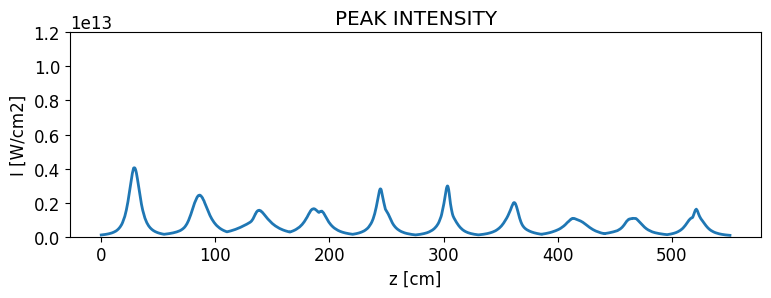

In [140]:
# PLOT PEAK INTENSITY
plt.figure(figsize=size_py_wide) 
plt.title("PEAK INTENSITY")
# plt.plot(z_total.*1e2, cat(dims=1, w_z...).*1e6)
plt.plot(z_total.*1e2, fac.*I_peak_fused)
plt.xlabel("z [cm]")
plt.ylabel("I [W/cm2]")
plt.ylim(0, 1.2e13)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "caustic.png"), dpi=res) 
end
plt.gcf()

In [141]:
# integrate peak intensity over z for each pass
I_peak_int = zeros(size(I_peak,2))
for ii = 1:size(I_peak, 2)
    I_peak_int[ii] = integrate(z, I_peak[:, ii], SimpsonEven());
end

In [142]:
n2 = params["n2"]
B_int = 2pi/λ0*n2*I_peak_int
B_int .*= PhysData.c*PhysData.ε_0/2

10-element Vector{Float64}:
 7.522227271134902
 6.440373704784676
 5.104518299657603
 5.326633932986158
 5.3065288275475915
 4.886383861225639
 4.293674110305554
 3.719846641044896
 3.3895376131392747
 3.6511762711198545

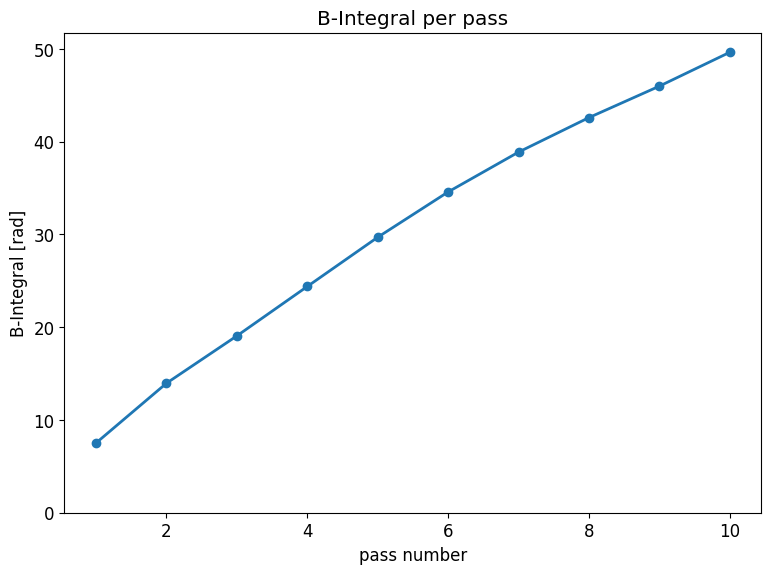

In [143]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, cumsum(B_int), marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

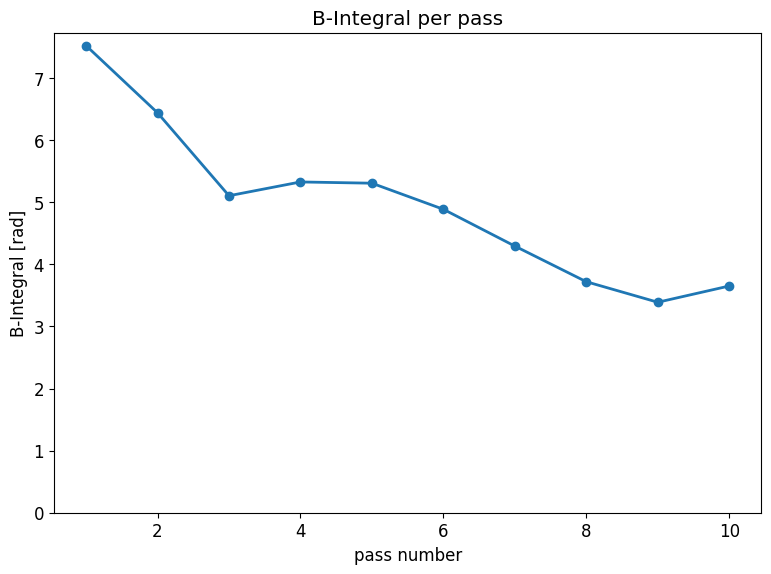

In [144]:
# PLOT B-integral per pass
plt.figure(figsize=size_py) 
plt.title("B-Integral per pass")
plt.plot(1:Npass, B_int, marker="o")
#plt.xticks(0:5:Npass)
plt.xlabel("pass number")
plt.ylabel("B-Integral [rad]")
plt.ylim(0,)
plt.tight_layout()
if save_figs 
    # plt.savefig(joinpath(run_path, "beam_waist_mirr.png"), dpi=res) 
end
plt.gcf()

In [145]:
# Expected accumulated B-Integral based on eq.8 in Viotti et al. 2022
E_pulse = params["E_pulse"]
τ = params["τ"]
k = params["k"]
Nrt = params["Npass"]/2

P_peak = 0.94*E_pulse/τ
B_pass = 4*pi^2*n2*P_peak/λ0^2*(k/Nrt)
B_total = Nrt*B_pass

println("B_pass = ", B_pass)
println("B_total = ", B_total)

B_pass = 2.4284347737935112
B_total = 12.142173868967557
